In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

In [2]:
def load_and_preprocess_data(data_path, image_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2  # Use 80% for training, 20% for validation
    )

    train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',  # Use 'categorical' for one-hot encoded labels
        subset='training'  # Use the training subset of the data
    )

    validation_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # Use the validation subset of the data
    )


    class_labels = {v: k for k, v in train_generator.class_indices.items()}

    return train_generator, validation_generator, class_labels

In [3]:
def build_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, train_generator, validation_generator, epochs):
    print("Train samples:", train_generator.samples)
    print("Validation samples:", validation_generator.samples)

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(train_generator,
                        steps_per_epoch=len(train_generator),
                        validation_data=validation_generator,
                        validation_steps=len(validation_generator),
                        epochs=epochs,
                        callbacks=[early_stopping],  # Add the early stopping callback
                        verbose=1)
    return history


In [5]:
def plot_training_history(history):
    # Plot the training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [6]:
data_path = "C:/Users/HP/OneDrive/Documents/Photos"
image_size = (224, 224)
batch_size = 32

train_generator, validation_generator, class_labels = load_and_preprocess_data(data_path, image_size, batch_size)

Found 73 images belonging to 5 classes.
Found 16 images belonging to 5 classes.


In [7]:
num_classes = len(class_labels)

model = build_model(num_classes)

Train samples: 73
Validation samples: 16
Epoch 1/50



3/3 [==============================] - 22s 6s/step - loss: 3.0231 - accuracy: 0.2192 - val_loss: 1.5611 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 18s 5s/step - loss: 1.7164 - accuracy: 0.4247 - val_loss: 0.8662 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 18s 5s/step - loss: 1.1290 - accuracy: 0.5342 - val_loss: 0.6289 - val_accuracy: 0.8750
Epoch 4/50
3/3 [==============================] - 18s 8s/step - loss: 0.9438 - accuracy: 0.6301 - val_loss: 0.4494 - val_accuracy: 0.9375
Epoch 5/50
3/3 [==============================] - 18s 5s/step - loss: 0.6013 - accuracy: 0.7671 - val_loss: 0.4748 - val_accuracy: 0.8750
Epoch 6/50
3/3 [==============================] - 18s 5s/step - loss: 0.6821 - accuracy: 0.6986 - val_loss: 0.3807 - val_accuracy: 0.9375
Epoch 7/50
3/3 [==============================] - 18s 8s/step - loss: 0.8277 - accuracy: 0.6027 - val_loss: 0.3042 - val_accuracy: 0.9375
Epoch 8/50
3/3 [=============================

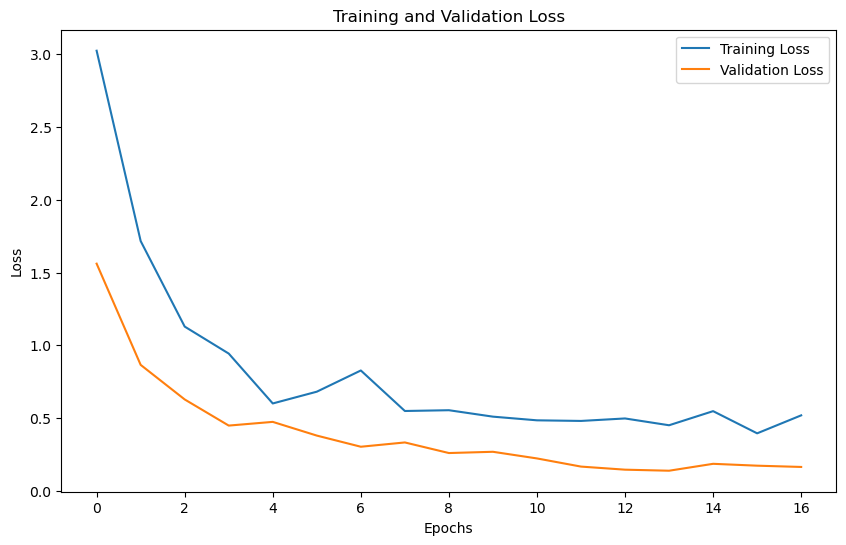

NameError: name 'X_test' is not defined

In [8]:
epochs = 50

history = train_model(model, train_generator, validation_generator, epochs)
plot_training_history(history)

In [9]:
validation_accuracy = model.evaluate(validation_generator)[1]
print("Validation Accuracy: {:.2f}%".format(validation_accuracy * 100))

1/1 [==============================] - 4s 4s/step - loss: 0.1842 - accuracy: 0.9375
Validation Accuracy: 93.75%


In [10]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from datetime import datetime
import csv

temp=0

def recognize_faces_and_log_attendance(model, class_labels):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)  # Use 0 for the default camera
    temp = 0
    
    while True:
        ret, frame = cap.read()

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            face_roi = frame[y:y+h, x:x+w]
            face_roi = cv2.resize(face_roi, (224, 224))
            face_roi = img_to_array(face_roi)
            face_roi = np.expand_dims(face_roi, axis=0)
            face_roi = preprocess_input(face_roi)

            predictions = model.predict(face_roi)
            mark_attendance(predictions[0], class_labels)

            label_index = np.argmax(predictions[0])
            student_name = class_labels[label_index]

            cv2.putText(frame, student_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        cv2.imshow('Attendance System', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

def mark_attendance(similarity_percentages, class_labels):
    global temp
    highest_similarity_index = np.argmax(similarity_percentages)
    highest_similarity_percentage = similarity_percentages[highest_similarity_index]

    if highest_similarity_percentage > 0.5:
        student_name = class_labels[highest_similarity_index]

        with open("Attendance.csv", 'a', newline='') as f:
            writer = csv.writer(f)
            my_data_list = []
            try:
                with open("Attendance.csv", 'r') as r:
                    reader = csv.reader(r)
                    my_data_list = list(reader)
            except FileNotFoundError:
                pass

            name_list = [entry[0] for entry in my_data_list]
            student_name = student_name.split('.')[0]
            reg_no = student_name.split(', ')[1]
            student_name = student_name.split(', ')[0]

            if student_name not in name_list:
                now = datetime.now()
                temp += 1
                time = now.strftime('%I:%M:%S:%p')
                date = now.strftime('%d-%B-%Y')
                print("Recognized:", student_name)  # Print the predicted face's name
                student_data = {"name": student_name, "reg_no": reg_no, "time": time, "date": date}
                writer.writerow([student_name, reg_no, time, date])
            f.close()

if __name__ == "__main__":
    recognize_faces_and_log_attendance(model, class_labels)


1/1 [==============================] - 0s 172ms/step
Recognized: Ramaraju_Sree_Virajitha
1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 157ms/step
